#**Import competition data from Kaggle**

In [ ]:
import pandas as pd
import numpy as np
import os

In [ ]:
#Upload kaggle.json

In [ ]:
os.environ["KAGGLE_CONFIG_DIR"] = "."

In [ ]:
!kaggle competitions download -c udea-ai4eng-20242
!unzip udea-ai4eng-20242

udea-ai4eng-20242.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  udea-ai4eng-20242.zip
replace submission_example.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 
error:  invalid response [{ENTER}]
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
#call train data
d = pd.read_csv("train.csv")
d.head()

,ID,PERIODO,ESTU_PRGM_ACADEMICO,ESTU_PRGM_DEPARTAMENTO,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_EDUCACIONPADRE,FAMI_EDUCACIONMADRE,ESTU_PAGOMATRICULAPROPIO,RENDIMIENTO_GLOBAL
0,904256,20212,ENFERMERIA,BOGOTÁ,Entre 5.5 millones y menos de 7 millones,Menos de 10 horas,Estrato 3,Si,Técnica o tecnológica incompleta,Postgrado,No,medio-alto
1,645256,20212,DERECHO,ATLANTICO,Entre 2.5 millones y menos de 4 millones,0,Estrato 3,No,Técnica o tecnológica completa,Técnica o tecnológica incompleta,No,bajo
2,308367,20203,MERCADEO Y PUBLICIDAD,BOGOTÁ,Entre 2.5 millones y menos de 4 millones,Más de 30 horas,Estrato 3,Si,Secundaria (Bachillerato) completa,Secundaria (Bachillerato) completa,No,bajo
3,470353,20195,ADMINISTRACION DE EMPRESAS,SANTANDER,Entre 4 millones y menos de 5.5 millones,0,Estrato 4,Si,No sabe,Secundaria (Bachillerato) completa,No,alto
4,989032,20212,PSICOLOGIA,ANTIOQUIA,Entre 2.5 millones y menos de 4 millones,Entre 21 y 30 horas,Estrato 3,Si,Primaria completa,Primaria completa,No,medio-bajo


# **Looking for correlations between variables**


*   bar plots





In [ ]:
#Prepare a list of columns which behaviour against target variable is of interest and you want to visualize through plots
columns = list(d.columns)


In [ ]:
columns.remove('ID')
columns.remove('ESTU_PRGM_ACADEMICO')
columns.remove('ESTU_PRGM_DEPARTAMENTO')
columns.remove('FAMI_TIENEINTERNET')
columns.remove('RENDIMIENTO_GLOBAL')


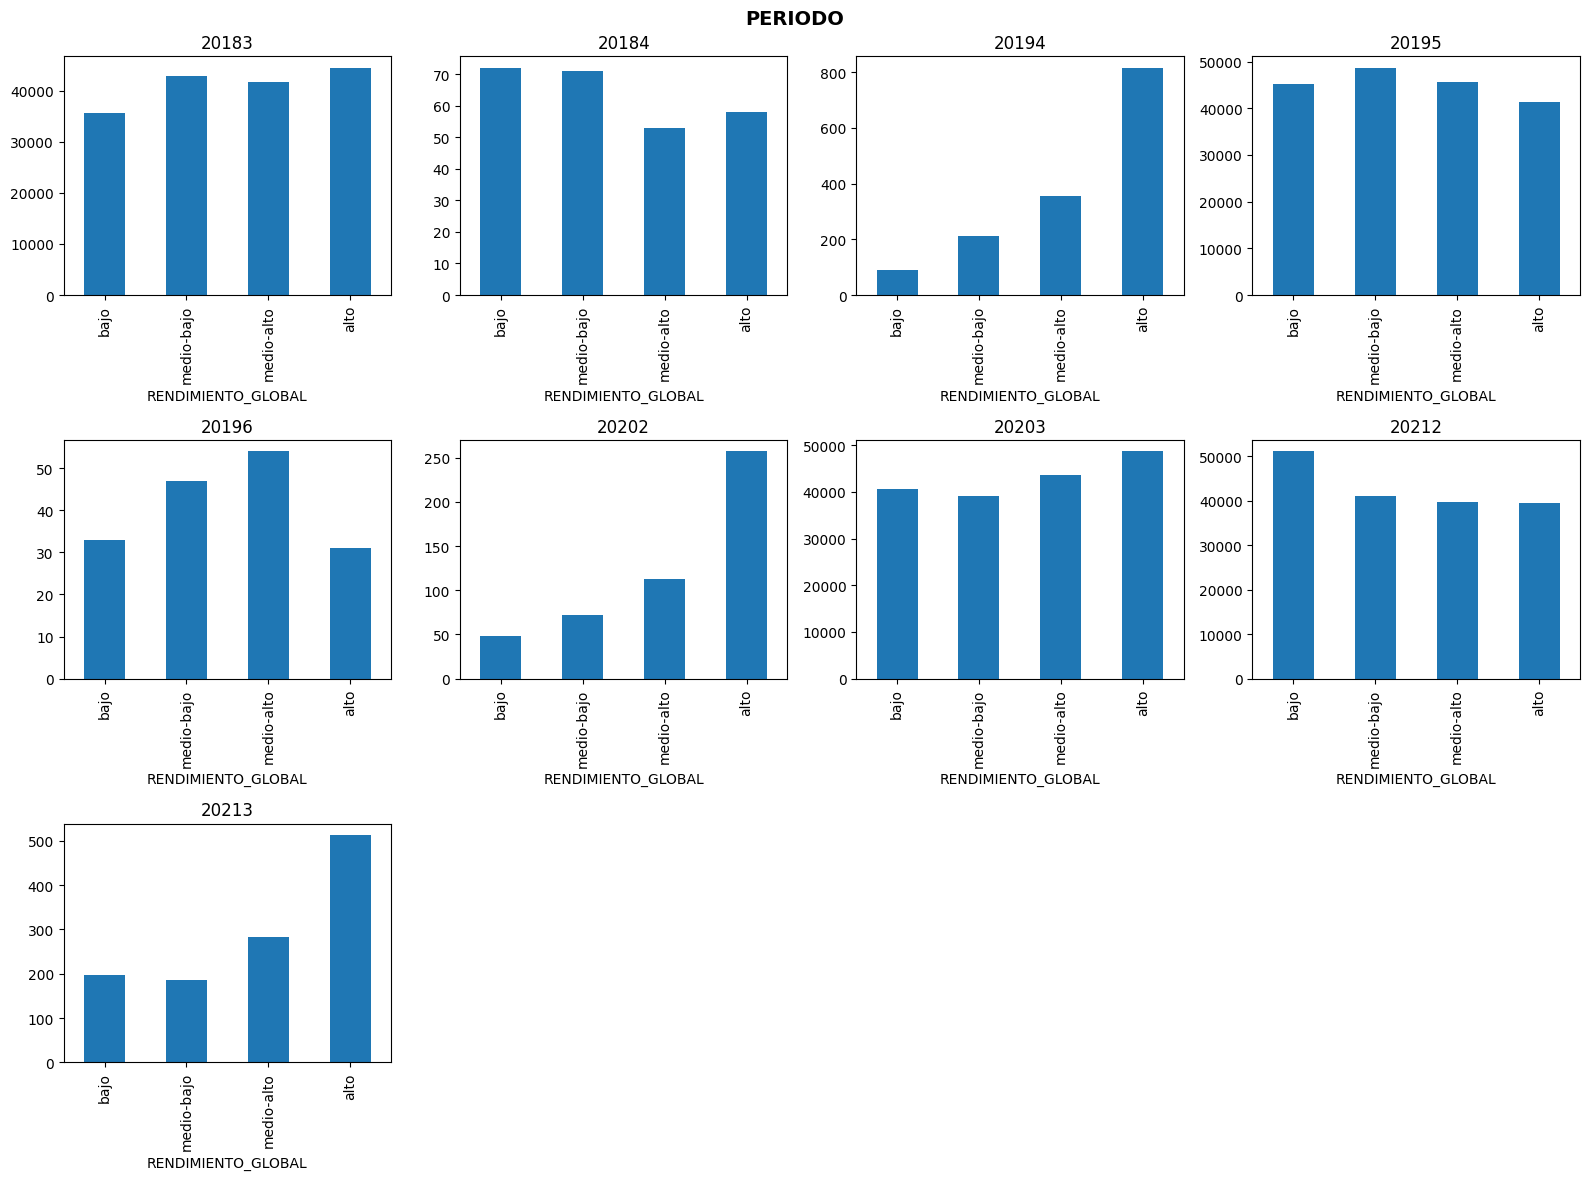

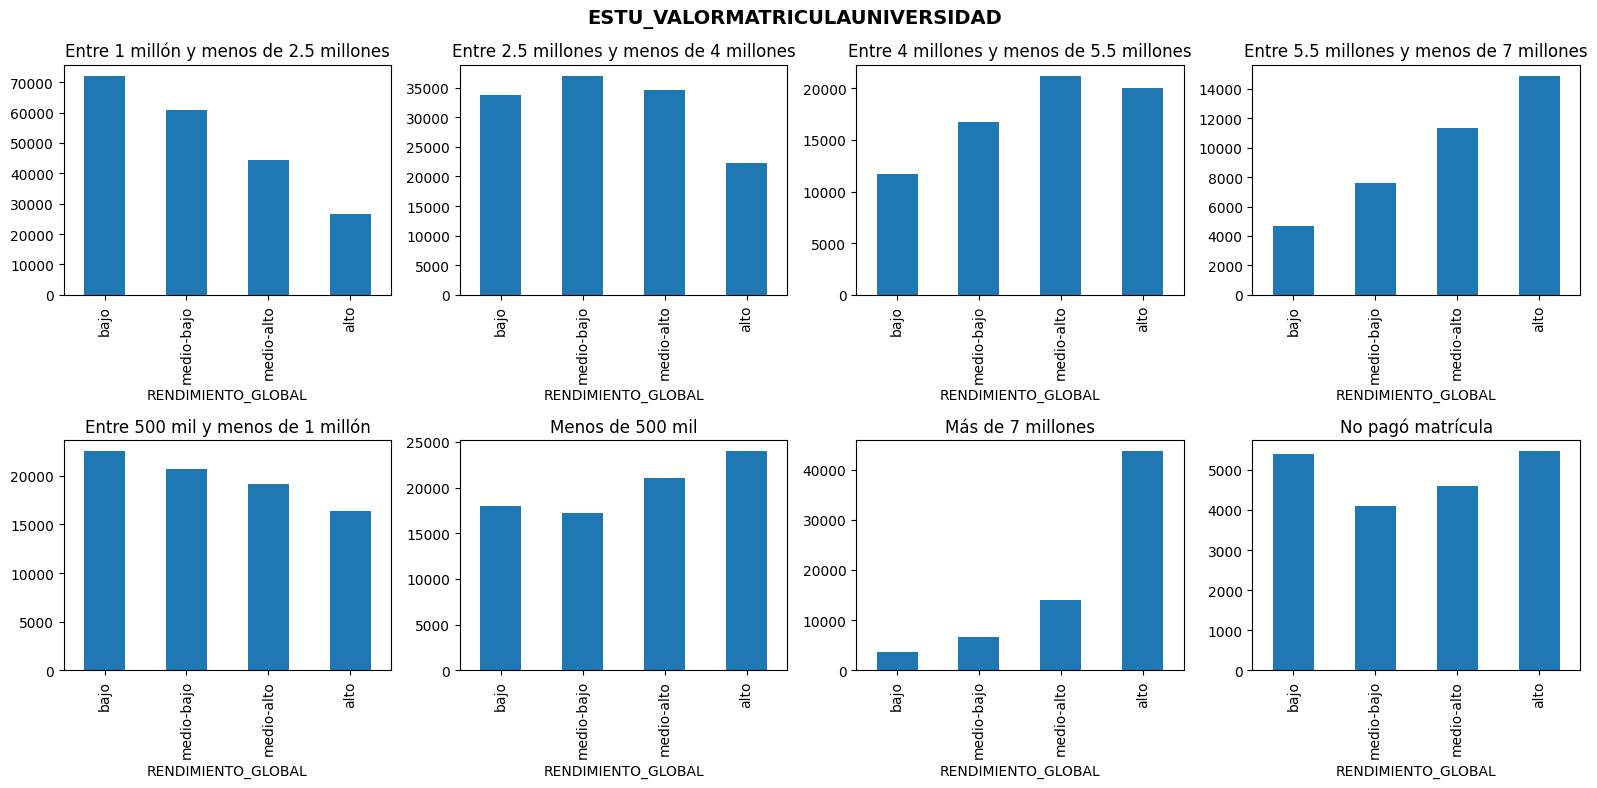

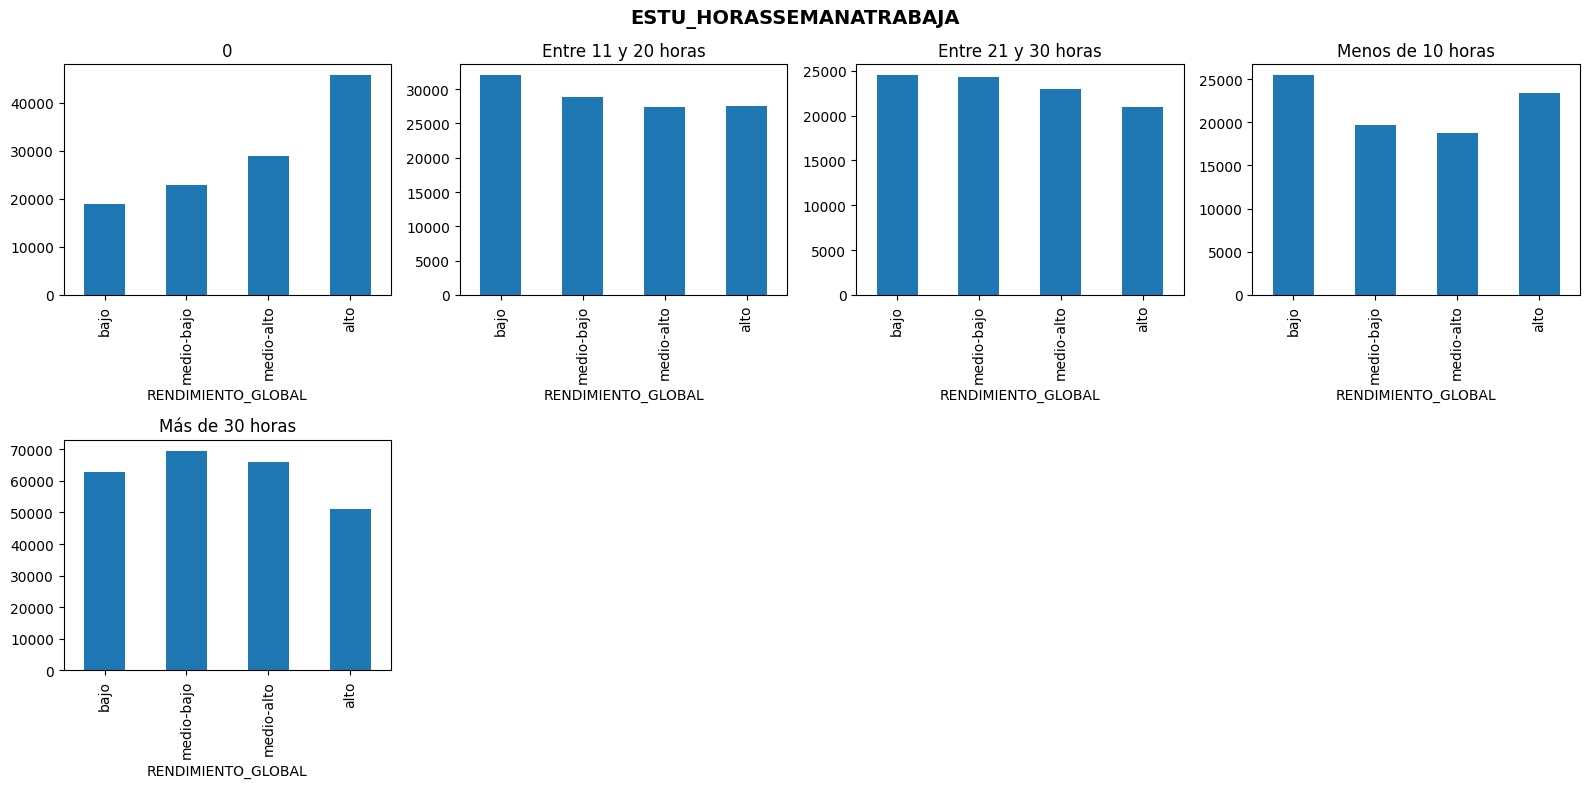

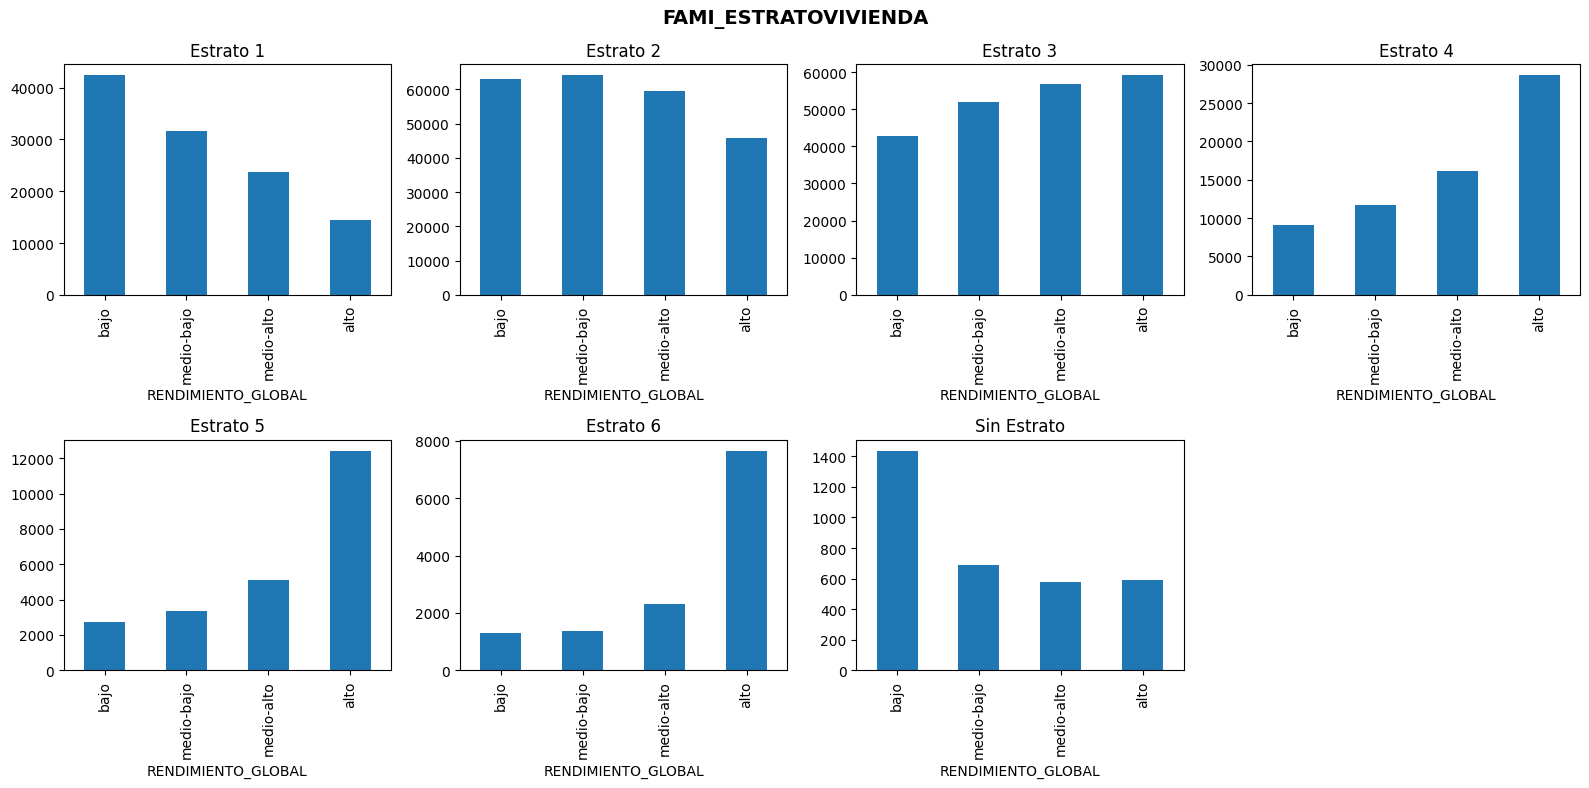

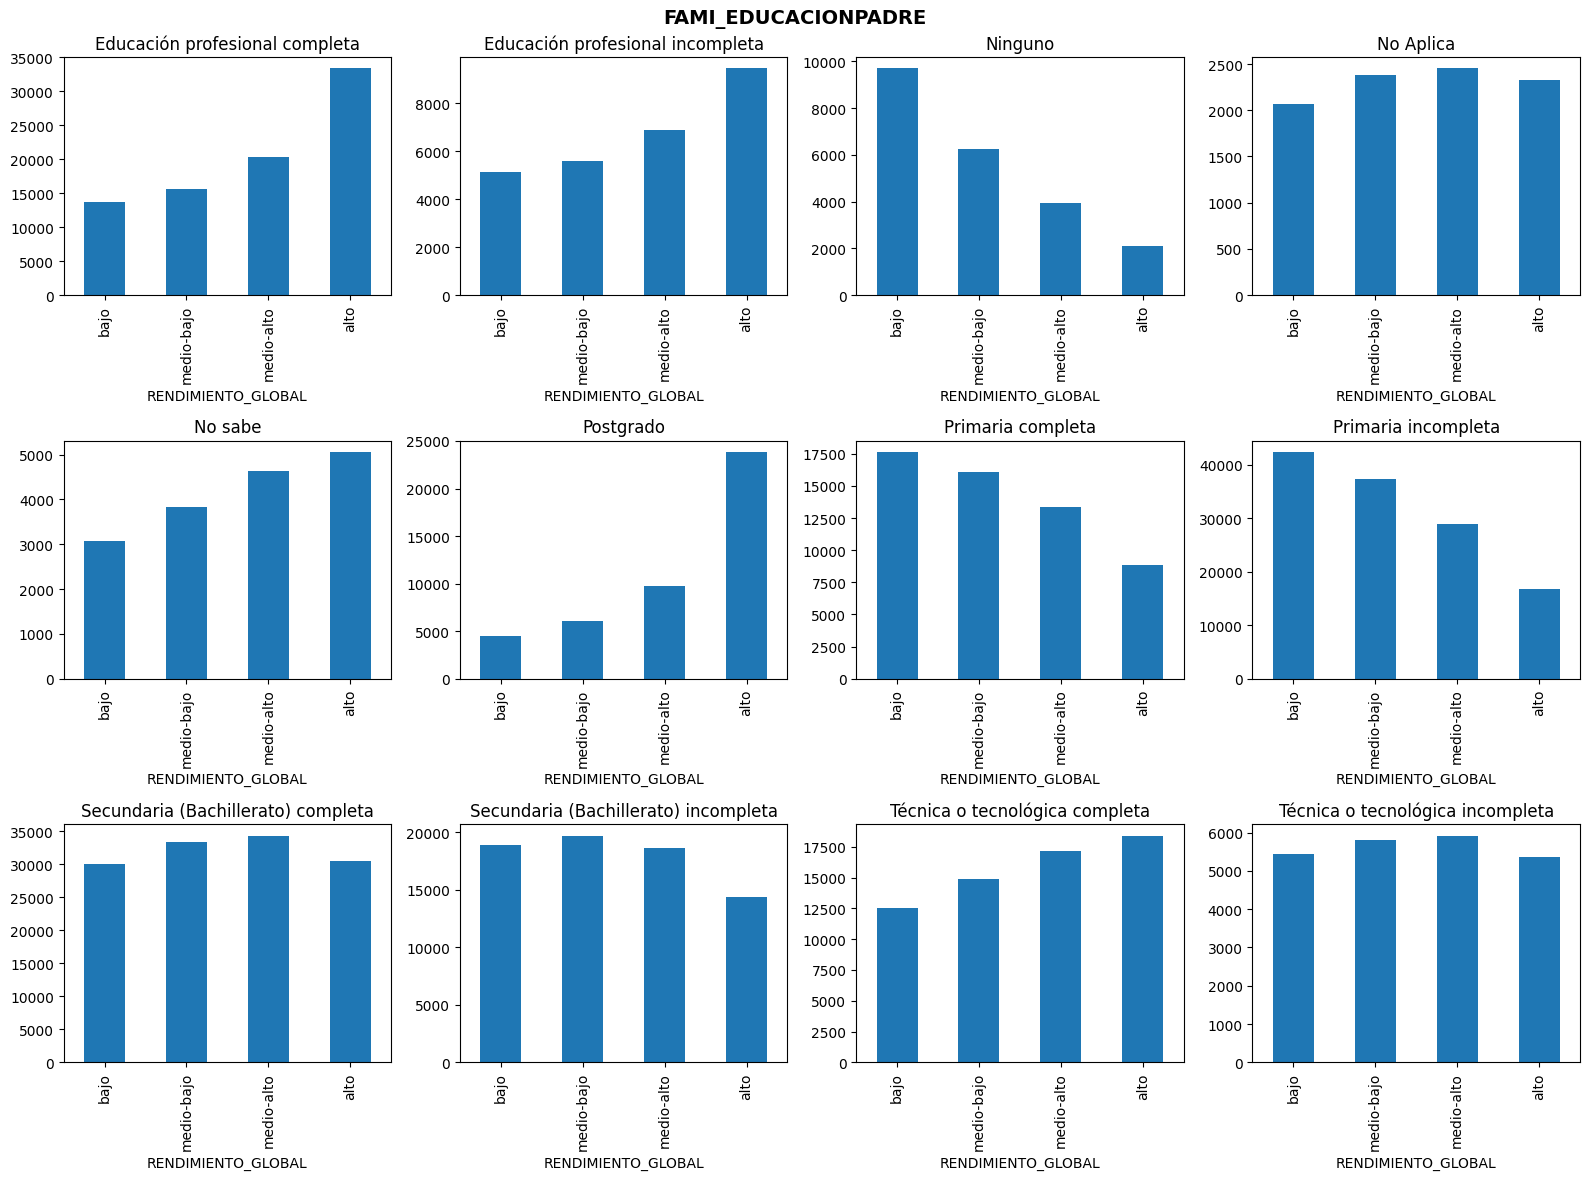

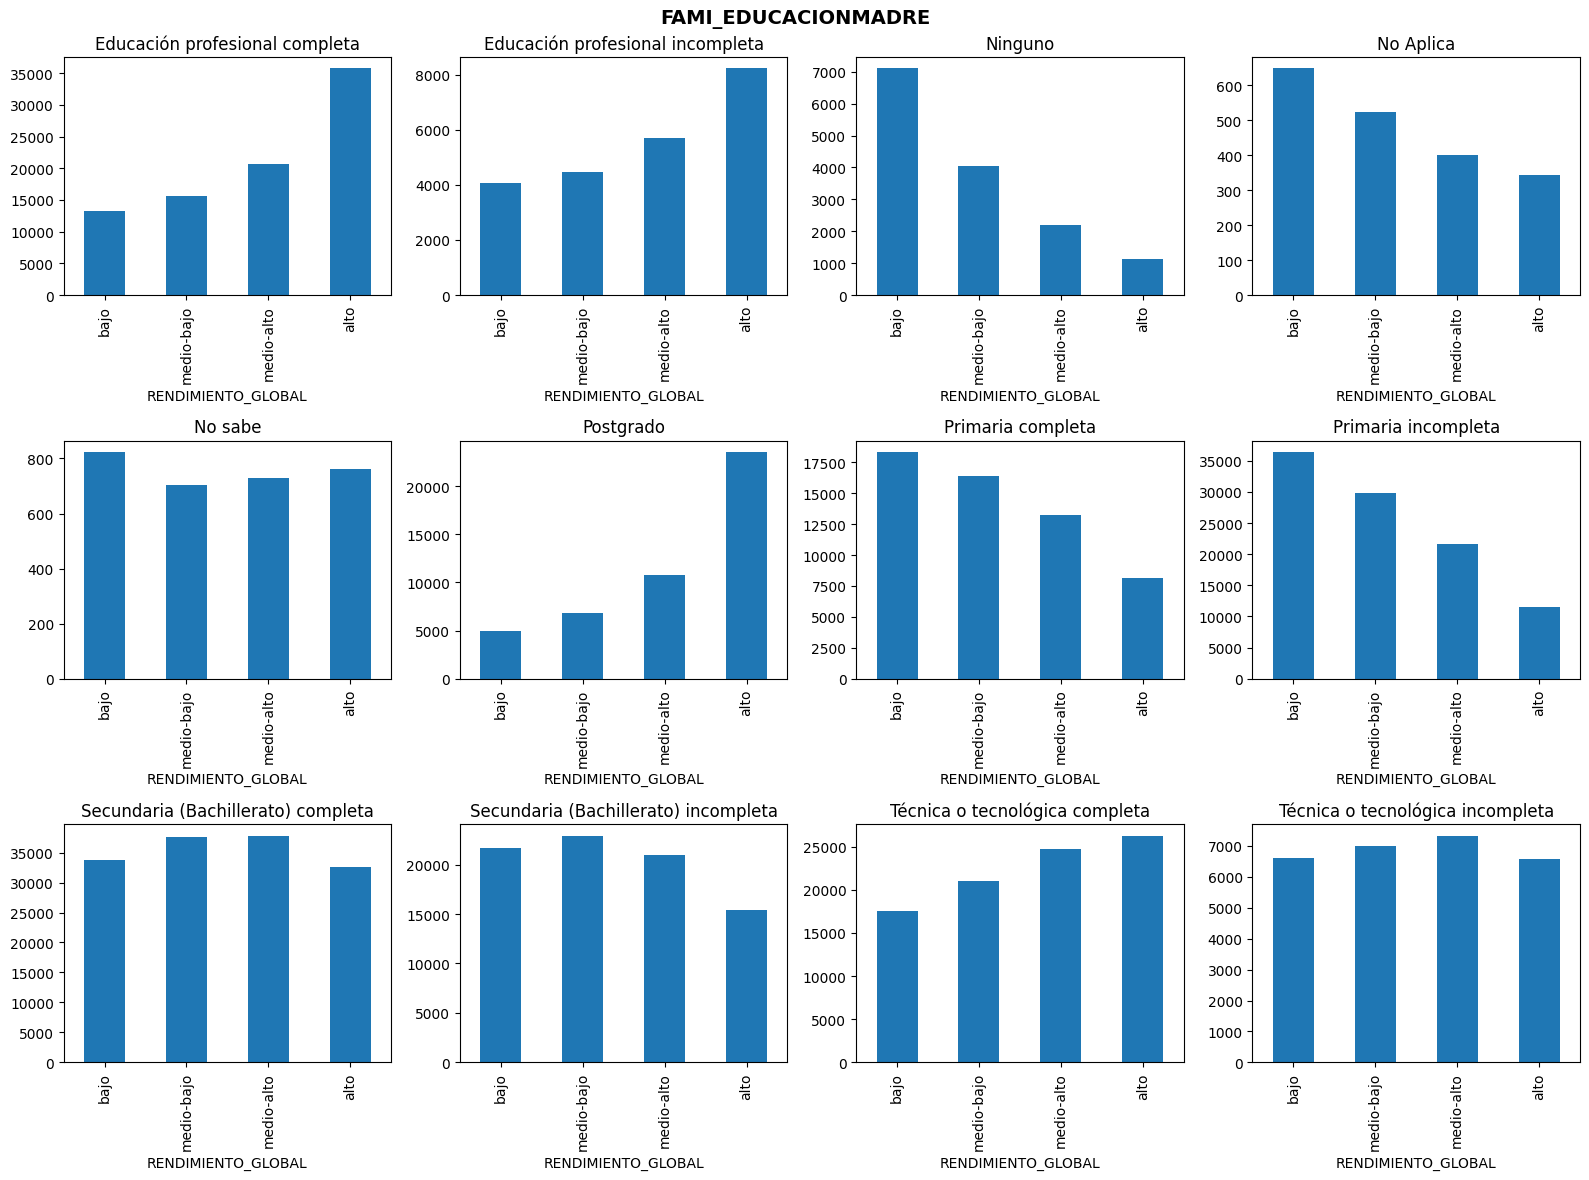

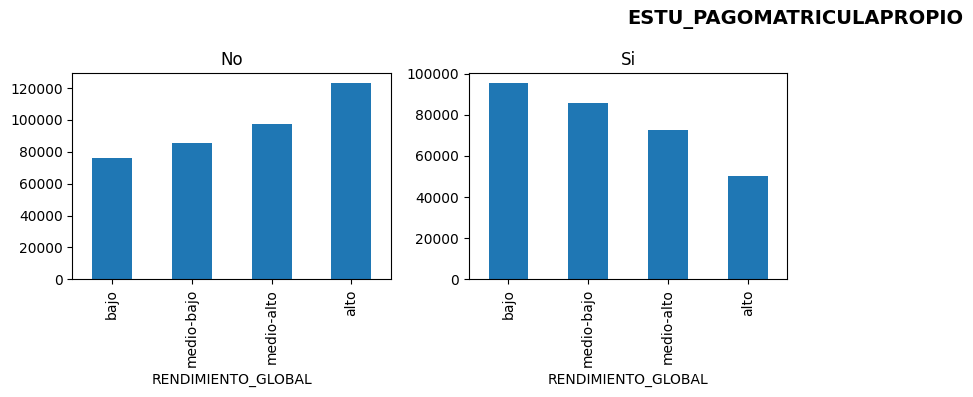

In [ ]:
#barplots of columns of interest vs RENDIMIENTO_GLOBAL
import matplotlib.pyplot as plt
for column in columns:
  # sorted unique values per column
  c = sorted(d[column].value_counts().index)

  #Dimensions of the grid of subplots
  cols = 4
  rows = (len(c) + cols - 1) // cols

  #Create subplots
  fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4), squeeze=False)

  #Plot each one in a subplot
  for idx, ci in enumerate(c):
      #create row and column index
      row = idx // cols
      col = idx % cols
      ax = axes[row, col]

      # Filter the data and create the plot
      dc = d[d[column] == ci]
      dc.RENDIMIENTO_GLOBAL.value_counts()[['bajo', 'medio-bajo', 'medio-alto', 'alto']].plot(kind='bar', ax=ax)
      # Set the title for each subplot
      ax.set_title(ci)
  # Remove empty subplots if there are any
  for i in range(len(c), rows * cols):
      fig.delaxes(axes[i // cols, i % cols])
  fig.suptitle(column, fontsize=14, fontweight='bold')
  plt.tight_layout()
  plt.show()


In [ ]:
d0= d.copy()
#Romove columns with too many categories and uninformative columns according to the bar plots above
#col_del = ["ID","ESTU_PRGM_ACADEMICO","ESTU_PRGM_DEPARTAMENTO", "FAMI_TIENEINTERNET"]
col_del = ["ID"]

for col in col_del:
  del(d0[col])

# **Understanding and adressing missing values**

* Count NaN values per column
*calculate contingency table
*Impute missing data according to the probability of occurrence obtained in a normalized contingency table

In [ ]:
#Existing NaN values
d0.isna().sum()

,0
PERIODO,0
ESTU_PRGM_ACADEMICO,0
ESTU_PRGM_DEPARTAMENTO,0
ESTU_VALORMATRICULAUNIVERSIDAD,6287
ESTU_HORASSEMANATRABAJA,30857
FAMI_ESTRATOVIVIENDA,32137
FAMI_TIENEINTERNET,26629
FAMI_EDUCACIONPADRE,23178
FAMI_EDUCACIONMADRE,23664
ESTU_PAGOMATRICULAPROPIO,6498


In [ ]:
#Remaining columns without RENDIMIENTO_GLOBAL
r_columns = list(d0.columns)
del(r_columns[-1])
r_columns

['PERIODO',
 'ESTU_PRGM_ACADEMICO',
 'ESTU_PRGM_DEPARTAMENTO',
 'ESTU_VALORMATRICULAUNIVERSIDAD',
 'ESTU_HORASSEMANATRABAJA',
 'FAMI_ESTRATOVIVIENDA',
 'FAMI_TIENEINTERNET',
 'FAMI_EDUCACIONPADRE',
 'FAMI_EDUCACIONMADRE',
 'ESTU_PAGOMATRICULAPROPIO']

In [ ]:
# Define a function to impute missing values based on the global proportions
global_proportions = {
    column: d0[column].value_counts(normalize=True)
    for column in r_columns
}

  # Define the imputation function
def impute_based_on_proportion(row, global_proportions):
    for column in r_columns:
        if pd.isna(row[column]):
            proportions = global_proportions[column].values
            categories = global_proportions[column].index

            # Impute a value based on the chosen proportions
            row[column] = np.random.choice(categories, p=proportions)
    return row

# Apply the imputation function to the DataFrame using global proportions
d1 = d0.apply(lambda row: impute_based_on_proportion(row, global_proportions), axis=1)

In [ ]:
#Check if null values are gone
d1.isna().sum()

,0
PERIODO,0
ESTU_PRGM_ACADEMICO,0
ESTU_PRGM_DEPARTAMENTO,0
ESTU_VALORMATRICULAUNIVERSIDAD,0
ESTU_HORASSEMANATRABAJA,0
FAMI_ESTRATOVIVIENDA,0
FAMI_TIENEINTERNET,0
FAMI_EDUCACIONPADRE,0
FAMI_EDUCACIONMADRE,0
ESTU_PAGOMATRICULAPROPIO,0


# **One-hot encoding, and getting data ready for model training**

Redefine some columns

In [ ]:
d2 = d1.copy()

In [ ]:
import pandas as pd
import unicodedata
def eliminar_tildes(palabra):
    return ''.join(
        c for c in unicodedata.normalize('NFD', palabra) if unicodedata.category(c) != 'Mn'
    ).lower()

# Creating a dictionary to map unique values to knowledge areas
knowledge_areas = {
    "ADMINISTRACION": [
      "ADMINISTRACION","BANCA","DIRECCION","GESTION","ARCHIVISTA","BIBLIOTECOLOGIA","BIENES", "GERENCIA"
    ],

    'EDUCACION Y PEDAGOGIA': [
        "PEDAGOGIA","ACTIVIDAD","DEPORTE","ENTRENAMIENTO","RECREACION","MAESTRO", "LICENCIATURA"
    ],

    'INGENIERIA Y TECNOLOGIA': [
        "INGENIERIA","CONTADURIA","INVESTIGACION","SISTEMAS","URBANISMO","MATEMATICAS","BIOINGENIERIA","BIOTECNOLOGIA","COMPUTACION","INFORMACION","CONSTRUCCION",
        "CONSTRUCCIONES","ESTADISTICA"
    ],
    'CIENCIAS DE LA SALUD': ["MEDICINA","NUTRICION","ODONTOLOGIA","OPTOMETRIA","SEGURIDAD","SALUD","TERAPIA","TERAPIAS","ENFERMERIA","FARMACIA","FISIOTERAPIA","FONOAUDIOLOGIA",
    "GERONTOLOGIA","QUIRURGICA"
    ],
    'DERECHO Y CIENCIAS POLITICAS': [
        "CRIMINALISTICA","MILITARES","NAUTICAS","NAVALES","POLITICA","POLITICAS","POLITICOS","DERECHO","DESARROLLO", "GOBIERNO", "JURISPRUDENCIA"

    ],
    "MERCADO Y NEGOCIOS":[
        "MERCADEO","MERCADOLOGIA","NEGOCIOS","AGRONEGOCIOS","FINANZAS","MARKETING","PUBLICIDAD","RELACIONES","COMERCIO","ECONOMIA","LOGISTICA"
    ],

    "ALIMENTACION":[
        "AGROINDUSTRIAL","AGRONOMIA","AGROINDUSTRIA","GASTROMONIA","TURISMO","HOTELERIA"
    ],
    'CIENCIAS SOCIALES Y PSICOLOGIA': [
        "PERIODISMO","SOCIAL","COMUNICACION","FILOSOFIA","PSICOLOGIA","PSICOLOGA","SOCIOLOGIA","TEOLOGIA", "ANTROPOLOGIA","ARQUEOLOGIA",
        "BIBLICAS", "HISTORIA"
    ],

    'CIENCIAS NATURALES': [
        "MICROBIOLOGIA","OCEANOGRAFIA","QUIMICA","ZOOTECNIA","ACUICULTURA","BACTERIOLOGIA","BIOLOGIA", "BIOQUIMICA","AMBIENTALES","ECOLOGIA", "FISICA","GEOGRAFIA","GEOCIENCIAS", "GEOLOGIA"
    ],

    'ARTES Y HUMANIDADES': [
        "MUSICA","MÚSICA","NARRATIVAS","ARTES","ARTE","CINE","DISEÑO","LENGUAS","MEDIOS","ANIMACION","TEATRO","TRADUCCION","LITERARIA","DANZA","FILOLOGIA","LITERARIOS","MUSICALES",
        "MUSICAL", "FOTOGRAFIA","LENGUAJES", "LINGUISTICA", "LITERATURA"

    ],
}

def mapear_area(categoria):
    categoria_sin_tildes = eliminar_tildes(categoria)
    for area, palabras_clave in knowledge_areas.items():
        # Convertimos las palabras clave a formato sin tildes y en minúsculas
        palabras_clave_sin_tildes = [eliminar_tildes(palabra) for palabra in palabras_clave]
        if any(palabra in categoria_sin_tildes for palabra in palabras_clave_sin_tildes):
            return area
    return 'OTRO'  # Si no se encuentra coincidencia, se asigna a 'OTRO'

# Aplicar la función de mapeo a la columna
d2['ESTU_PRGM_ACADEMICO'] = d2['ESTU_PRGM_ACADEMICO'].apply(mapear_area)


In [ ]:
d2.ESTU_PRGM_ACADEMICO.value_counts()

,count
ESTU_PRGM_ACADEMICO,
INGENIERIA Y TECNOLOGIA,203883
ADMINISTRACION,131927
CIENCIAS SOCIALES Y PSICOLOGIA,86087
EDUCACION Y PEDAGOGIA,70035
DERECHO Y CIENCIAS POLITICAS,60669
CIENCIAS DE LA SALUD,59113
MERCADO Y NEGOCIOS,34826
ARTES Y HUMANIDADES,18903
OTRO,12973


In [ ]:
# Define the manual mapping for "RENDIMIENTO_GLOBAL"
DICT_RENDIMIENTO= {"medio-alto": 2, 'bajo': 0, 'medio-bajo': 1, 'alto':3}
# Apply the mapping to the 'RENDIMIENTO_GLOBALD' column
d2.loc[:,'RENDIMIENTO_GLOBAL'] = d2["RENDIMIENTO_GLOBAL"].map(DICT_RENDIMIENTO)

In [ ]:
dX=d2.copy()
dX.shape

(692500, 11)

In [ ]:
#One-hot encode columns containing categorical variables
DF_ENCODED = pd.get_dummies(dX, columns=["PERIODO","ESTU_PRGM_ACADEMICO","ESTU_PRGM_DEPARTAMENTO","ESTU_VALORMATRICULAUNIVERSIDAD","ESTU_HORASSEMANATRABAJA","FAMI_ESTRATOVIVIENDA","FAMI_EDUCACIONMADRE","FAMI_EDUCACIONPADRE","ESTU_PAGOMATRICULAPROPIO","FAMI_TIENEINTERNET"], drop_first=True)

In [ ]:
col_del_oh = list(dX.columns)
for col in col_del_oh:
    if col not in ["PERIODO","ESTU_PRGM_ACADEMICO","ESTU_PRGM_DEPARTAMENTO","ESTU_VALORMATRICULAUNIVERSIDAD","ESTU_HORASSEMANATRABAJA","FAMI_ESTRATOVIVIENDA","FAMI_EDUCACIONMADRE","FAMI_EDUCACIONPADRE","ESTU_PAGOMATRICULAPROPIO","FAMI_TIENEINTERNET"]:
        del DF_ENCODED[col]
DF_ENCODED.shape

(692500, 89)

In [ ]:
#concatenate discrete and one-hot encoded columns, making sure the data is added as numeric type
d3 = pd.concat([DF_ENCODED.astype(int).reset_index(drop=True), dX['RENDIMIENTO_GLOBAL'].astype(int).reset_index(drop=True)],axis=1)

In [ ]:
d3.shape

(692500, 90)

# **Model selection and model training processess**

Build X and y

In [ ]:
d4 = d3[sorted(d3.columns)]

X = d4[[c for c in d4.columns if c!="RENDIMIENTO_GLOBAL" ]].values
y = d3["RENDIMIENTO_GLOBAL"].values
X1 = X[:100000]
y1 = y[:100000]
X1.shape, y1.shape

((100000, 89), (100000,))

Split the training dataset into test and train/val data

In [ ]:
from sklearn.model_selection import train_test_split

train_size = 0.7

Xtr, Xts, ytr, yts = train_test_split(X1, y1, train_size=train_size)
print (Xtr.shape, Xts.shape)

(70000, 89) (30000, 89)


Cross validation and model selection

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [ ]:
gb = GradientBoostingClassifier(n_estimators= 200, max_depth=3, learning_rate=0.08)
lr= LogisticRegression(max_iter=3000)

In [ ]:
print(cross_val_score(lr,Xtr,ytr).mean())
print(cross_val_score(gb,Xtr,ytr).mean())

0.4100857142857143
0.4086428571428571


Best model : gb

Prepare test.csv

In [ ]:
test = pd.read_csv("test.csv")
test_ids=test["ID"].values

In [ ]:
def clean_test(df):
  import pandas as pd
  d0= df.copy()
  col_del = ["ID"]

  for col in col_del:
    del(d0[col])
  r_columns = list(d0.columns)
  global_proportions = {
    column: d0[column].value_counts(normalize=True)
    for column in r_columns
}

  # Define the imputation function
  def impute_based_on_proportion(row, global_proportions):
    for column in r_columns:
        if pd.isna(row[column]):
            proportions = global_proportions[column].values
            categories = global_proportions[column].index

            # Impute a value based on the chosen proportions
            row[column] = np.random.choice(categories, p=proportions)
    return row

# Apply the imputation function to the DataFrame using global proportions as a fallback
  d1 = d0.apply(lambda row: impute_based_on_proportion(row, global_proportions), axis=1)
  import unicodedata
  def eliminar_tildes(palabra):
    return ''.join(
        c for c in unicodedata.normalize('NFD', palabra) if unicodedata.category(c) != 'Mn'
    ).lower()

  # Creating a dictionary to map unique values to knowledge areas
  knowledge_areas = {
    "ADMINISTRACION": [
      "ADMINISTRACION","BANCA","DIRECCION","GESTION","ARCHIVISTA","BIBLIOTECOLOGIA","BIENES", "GERENCIA"
    ],

    'EDUCACION Y PEDAGOGIA': [
        "PEDAGOGIA","ACTIVIDAD","DEPORTE","ENTRENAMIENTO","RECREACION","MAESTRO", "LICENCIATURA"
    ],

    'INGENIERIA Y TECNOLOGIA': [
        "INGENIERIA","CONTADURIA","INVESTIGACION","SISTEMAS","URBANISMO","MATEMATICAS","BIOINGENIERIA","BIOTECNOLOGIA","COMPUTACION","INFORMACION","CONSTRUCCION",
        "CONSTRUCCIONES","ESTADISTICA"
    ],
    'CIENCIAS DE LA SALUD': ["MEDICINA","NUTRICION","ODONTOLOGIA","OPTOMETRIA","SEGURIDAD","SALUD","TERAPIA","TERAPIAS","ENFERMERIA","FARMACIA","FISIOTERAPIA","FONOAUDIOLOGIA",
    "GERONTOLOGIA","QUIRURGICA"
    ],
    'DERECHO Y CIENCIAS POLITICAS': [
        "CRIMINALISTICA","MILITARES","NAUTICAS","NAVALES","POLITICA","POLITICAS","POLITICOS","DERECHO","DESARROLLO", "GOBIERNO", "JURISPRUDENCIA"

    ],
    "MERCADO Y NEGOCIOS":[
        "MERCADEO","MERCADOLOGIA","NEGOCIOS","AGRONEGOCIOS","FINANZAS","MARKETING","PUBLICIDAD","RELACIONES","COMERCIO","ECONOMIA","LOGISTICA"
    ],

    "ALIMENTACION":[
        "AGROINDUSTRIAL","AGRONOMIA","AGROINDUSTRIA","GASTROMONIA","TURISMO","HOTELERIA"
    ],
    'CIENCIAS SOCIALES Y PSICOLOGIA': [
        "PERIODISMO","SOCIAL","COMUNICACION","FILOSOFIA","PSICOLOGIA","PSICOLOGA","SOCIOLOGIA","TEOLOGIA", "ANTROPOLOGIA","ARQUEOLOGIA",
        "BIBLICAS", "HISTORIA"
    ],

    'CIENCIAS NATURALES': [
        "MICROBIOLOGIA","OCEANOGRAFIA","QUIMICA","ZOOTECNIA","ACUICULTURA","BACTERIOLOGIA","BIOLOGIA", "BIOQUIMICA","AMBIENTALES","ECOLOGIA", "FISICA","GEOGRAFIA","GEOCIENCIAS", "GEOLOGIA"
    ],

    'ARTES Y HUMANIDADES': [
        "MUSICA","MÚSICA","NARRATIVAS","ARTES","ARTE","CINE","DISEÑO","LENGUAS","MEDIOS","ANIMACION","TEATRO","TRADUCCION","LITERARIA","DANZA","FILOLOGIA","LITERARIOS","MUSICALES",
        "MUSICAL", "FOTOGRAFIA","LENGUAJES", "LINGUISTICA", "LITERATURA"

    ],
}

  def mapear_area(categoria):
    categoria_sin_tildes = eliminar_tildes(categoria)
    for area, palabras_clave in knowledge_areas.items():
        # Convertimos las palabras clave a formato sin tildes y en minúsculas
        palabras_clave_sin_tildes = [eliminar_tildes(palabra) for palabra in palabras_clave]
        if any(palabra in categoria_sin_tildes for palabra in palabras_clave_sin_tildes):
            return area
    return 'OTRO'  # Si no se encuentra coincidencia, se asigna a 'OTRO'

  # Aplicar la función de mapeo a la columna
  d1['ESTU_PRGM_ACADEMICO'] = d1['ESTU_PRGM_ACADEMICO'].apply(mapear_area)
  #One-hot encode columns containing categorical variables
  DF_ENCODED = pd.get_dummies(d1, columns=["PERIODO","ESTU_PRGM_ACADEMICO","ESTU_PRGM_DEPARTAMENTO","ESTU_VALORMATRICULAUNIVERSIDAD","ESTU_HORASSEMANATRABAJA","FAMI_ESTRATOVIVIENDA","FAMI_EDUCACIONMADRE","FAMI_EDUCACIONPADRE","ESTU_PAGOMATRICULAPROPIO","FAMI_TIENEINTERNET"], drop_first=True)
  col_del_oh = list(d1.columns)
  for col in col_del_oh:
    if col not in ["PERIODO","ESTU_PRGM_ACADEMICO","ESTU_PRGM_DEPARTAMENTO","ESTU_VALORMATRICULAUNIVERSIDAD","ESTU_HORASSEMANATRABAJA","FAMI_ESTRATOVIVIENDA","FAMI_EDUCACIONMADRE","FAMI_EDUCACIONPADRE","ESTU_PAGOMATRICULAPROPIO","FAMI_TIENEINTERNET"]:
        del DF_ENCODED[col]
  d_ts = pd.concat([DF_ENCODED.astype(int).reset_index(drop=True)],axis=1)
  return d_ts
test_data = clean_test(test)

Build X test array

In [ ]:
X_test_data = test_data[sorted(test_data.columns)].values
X_test_data.shape

(296786, 89)

Train the best model with all data

In [ ]:
gb.fit(X,y)

GradientBoostingClassifier(learning_rate=0.08, n_estimators=200)

# **Prediction and submission**

In [ ]:
preds_test_data = gb.predict(X_test_data)
preds_test_data.shape

(296786,)

In [ ]:
# Map back predictions
REVERSE_MAP = {v:k for k,v in DICT_RENDIMIENTO.items()}
text_preds_test_data = [REVERSE_MAP[i] for i in preds_test_data]

In [ ]:
# create dataframe
submission = pd.DataFrame([test_ids, text_preds_test_data], index=['ID', 'RENDIMIENTO_GLOBAL']).T

In [ ]:
# save to file ready to submit
submission.to_csv("my_submission.csv", index=False)

In [ ]:
!head my_submission.csv
submission.shape

ID,RENDIMIENTO_GLOBAL
550236,bajo
98545,medio-alto
499179,alto
782980,bajo
785185,bajo
58495,bajo
705444,alto
557548,alto
519909,bajo


(296786, 2)

In [ ]:
!kaggle competitions submit -c udea-ai4eng-20242 -f my_submission.csv -m "Brahiam Fernandez submission using GradientBoostingClassifier"

100% 4.02M/4.02M [00:01<00:00, 4.02MB/s]
Successfully submitted to UDEA/ai4eng 20242 - Pruebas Saber Pro Colombia